In [13]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

* raw audio = 441000
* Tx = 5511
* pydub audio synthesiser = 10000 (discretise 10sec clip into 0.001 second intervals)
* Ty = 1375 (dicretise the 10s into 1375 time intervals, each of length 0.0072s)

In [14]:
Tx = 5511 # number of time steps input to the model from the spectrogram
n_Freq = 101 # number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # number of time steps in the output of our model

In [15]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model

In [16]:
import tensorflow

In [17]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [18]:
# input = frequency spectrogram, labeled location of audio samples

def model(input_shape):
    X_input = Input(shape = input_shape)
    
    # Step1: Conv Layer
    X = Conv1D(196, kernel_size=15, strides = 4)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(0.8)(X)
    
    #Step2: GRU Layer
    X = GRU(units = 128, return_sequences = True)(X)
    X = Dropout(0.8)(X)
    X = BatchNormalization()(X)
    
    #Step3: GRU Layer
    X = GRU(units = 128, return_sequences = True)(X)
    X = Dropout(0.8)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.8)(X)
    
    #Step4: Time-distributed Dense Layer
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    model = Model(inputs = X_input, outputs = X)
    return model

In [19]:
model = model(input_shape = (Tx, n_Freq))

In [20]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1375, 128)         0         
__________

## Training the Model

In [21]:
training_history = []

In [22]:
opt = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
X = np.load("/home/liu181/Desktop/sample_generator/Network_Inputs/x_inputs_0.npy")
Y = np.load("/home/liu181/Desktop/sample_generator/Network_Inputs/y_inputs_0.npy")
X = np.transpose(X,(0, 2, 1))
Y = np.transpose(Y, (0, 2, 1))

In [23]:
history = model.fit(X, Y, batch_size = 10, epochs = 2)
training_history.append(history.history)
model.save("/home/liu181/Desktop/sample_generator/trigger_word_detection/models/tr_model.h5")

Epoch 1/2
200/200 [==============================] - 40s 200ms/step - loss: 1.3148 - acc: 0.5215
Epoch 2/2
200/200 [==============================] - 39s 193ms/step - loss: 1.1121 - acc: 0.5544


In [31]:
for sample_index in range (1, 60):
    print('Iteration: ', sample_index)
    # model = load_model("/home/liu181/Desktop/sample_generator/trigger_word_detection/models/tr_model.h5")
    X = np.load("/home/liu181/Desktop/sample_generator/Network_Inputs/x_inputs_"+str(sample_index)+".npy")
    Y = np.load("/home/liu181/Desktop/sample_generator/Network_Inputs/y_inputs_"+str(sample_index)+".npy")
    X = np.transpose(X,(0, 2, 1))
    Y = np.transpose(Y, (0, 2, 1))
    history = model.fit(X, Y, batch_size = 10, epochs = 2)
    training_history.append(history.history)
    print('Length of training history: ', len(training_history))
    # model.save("/home/liu181/Desktop/sample_generator/trigger_word_detection/models/tr_model.h5")

Iteration:  1
Epoch 1/2
200/200 [==============================] - 36s 182ms/step - loss: 0.3055 - acc: 0.9179
Epoch 2/2
200/200 [==============================] - 36s 180ms/step - loss: 0.3048 - acc: 0.9183
Length of training history:  61
Iteration:  2
Epoch 1/2
200/200 [==============================] - 36s 180ms/step - loss: 0.3122 - acc: 0.9183
Epoch 2/2
200/200 [==============================] - 36s 180ms/step - loss: 0.3104 - acc: 0.9184
Length of training history:  62
Iteration:  3
Epoch 1/2
200/200 [==============================] - 45s 225ms/step - loss: 0.3088 - acc: 0.9158
Epoch 2/2
200/200 [==============================] - 37s 183ms/step - loss: 0.3132 - acc: 0.9149
Length of training history:  63
Iteration:  4
Epoch 1/2
200/200 [==============================] - 36s 181ms/step - loss: 0.3055 - acc: 0.9201
Epoch 2/2
200/200 [==============================] - 36s 180ms/step - loss: 0.3034 - acc: 0.9202
Length of training history:  64
Iteration:  5
Epoch 1/2
200/200 [=======

Epoch 1/2
200/200 [==============================] - 58s 289ms/step - loss: 0.2930 - acc: 0.9207
Epoch 2/2
200/200 [==============================] - 61s 305ms/step - loss: 0.2951 - acc: 0.9206
Length of training history:  95
Iteration:  36
Epoch 1/2
200/200 [==============================] - 60s 301ms/step - loss: 0.2922 - acc: 0.9202
Epoch 2/2
200/200 [==============================] - 61s 306ms/step - loss: 0.2920 - acc: 0.9205
Length of training history:  96
Iteration:  37
Epoch 1/2
200/200 [==============================] - 58s 291ms/step - loss: 0.2926 - acc: 0.9219
Epoch 2/2
200/200 [==============================] - 54s 268ms/step - loss: 0.2887 - acc: 0.9225
Length of training history:  97
Iteration:  38
Epoch 1/2
200/200 [==============================] - 58s 291ms/step - loss: 0.2935 - acc: 0.9213
Epoch 2/2
200/200 [==============================] - 60s 301ms/step - loss: 0.2931 - acc: 0.9214
Length of training history:  98
Iteration:  39
Epoch 1/2
200/200 [=================

In [32]:
model.save("/home/liu181/Desktop/sample_generator/trigger_word_detection/models/tr_model_new.h5")

Text(0, 0.5, 'Accuracy (%)')

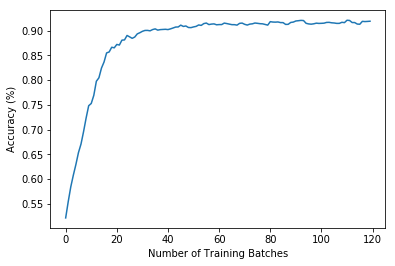

In [27]:
new_history = [d['acc'] for d in training_history]
new_history = sum(new_history, [])
plt.plot(new_history)
plt.xlabel("Number of Training Batches")
plt.ylabel("Accuracy (%)")

This looks pretty good! However, accuracy isn't a great metric for this task, since the labels are heavily skewed to 0's, so a neural network that just outputs 0's would get slightly over 90% accuracy. We could define more useful metrics such as F1 score or Precision/Recall. But let's not bother with that here, and instead just empirically see how the model does. 

## Testing the Model

In [33]:
# model = load_model("/home/liu181/Desktop/sample_generator/trigger_word_detection/models/tr_model.h5")

for i in range(0,5):
    X_dev = np.load("/home/liu181/Desktop/sample_generator/Dev_Inputs/x_inputs_"+str(i)+".npy")
    Y_dev = np.load("/home/liu181/Desktop/sample_generator/Dev_Inputs/y_inputs_"+str(i)+".npy")
    X_dev = np.transpose(X_dev,(0, 2, 1))
    Y_dev = np.transpose(Y_dev, (0, 2, 1))
    loss, acc = model.evaluate(X_dev, Y_dev)
    print("Dev set accuracy = ", acc)

200/200 [==============================] - 7s 34ms/step
Dev set accuracy =  0.9506290793418884
200/200 [==============================] - 7s 35ms/step
Dev set accuracy =  0.9509236359596253
200/200 [==============================] - 7s 36ms/step
Dev set accuracy =  0.9502254486083984
200/200 [==============================] - 7s 36ms/step
Dev set accuracy =  0.948621814250946
200/200 [==============================] - 7s 35ms/step
Dev set accuracy =  0.950334541797638


## Marking Predictions

In [63]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    #  = x.swapaxes(0,1)
    # = np.expand_dims(x, axis=0)
    x = np.transpose(x)
    x = np.expand_dims(x, axis = 0)
    
    predictions = model.predict(x)
    print(predictions[0, :, 0])
    
    new_prediction = predictions[0, :, 0]>0.5
    
    plt.subplot(2, 1, 2)
    plt.plot(new_prediction)
    plt.ylabel('probability')
    plt.show()
    return predictions

[0.12474832 0.12310232 0.12067499 ... 0.017977   0.01788153 0.01783532]


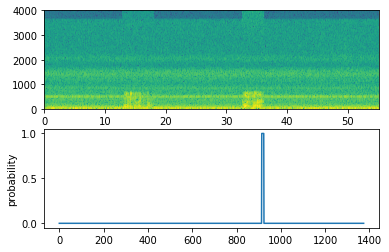

In [67]:
filename = '/home/liu181/Desktop/sample_generator/test_samples/sample_363.wav'
prediction = detect_triggerword(filename)
IPython.display.Audio(filename)

In [55]:
print(prediction[0, 1170, 0])

0.5174106


In [ ]:
model.save("/home/liu181/Desktop/sample_generator/trigger_word_detection/models/tr_model.h5")